In [1]:
import networkx as nx
from gurobipy import *
import random
import numpy as np
import matplotlib.pyplot as plt 
import copy
import timeit
import time
import subprocess
import pickle
def plotp (m):
    data=m[::-1,:]
    heatmap = plt.pcolor(data, cmap=plt.cm.tab20, edgecolors='grey', linewidths=2)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.0f' % data[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.show()
def start (w,h):
    arr = np.zeros(w*h,dtype=int) 
    arr[:random.randrange(0, w*h+1)]  = 1
    np.random.shuffle(arr)
    g = np.reshape(arr,(w,h))
    return g
g=start(5,5)

In [2]:
def ln(g):
    def sechseck(g):
        st = timeit.default_timer()
        for i in range(len(g)-1):
            for j in range(len(g[0])-1):
                if g[i,j]>0:
                    if g[i+1,j]>0 and g[i,j+1]>0 and g[i+1,j+1]>0:
                        if (i+2 <len(g) and g[i+2,j]>0 and g[i+2,j+1]>0) or (j+2 < len(g[0]) and g[i,j+2]>0 and g[i+1,j+2]>0):
                            return True
        return False
    def rest(g):
        st = timeit.default_timer()
        for i in range(1,len(g)-1):
            for j in range(1,len(g[0])-1):
                if g[i,j-1]==1 and g[i-1,j]==1 and g[i,j]==1 and g[i+1,j]==1 and g[i,j+1]==1 and ((g[i-1,j+1]==1 and g[i+1,j-1]==1) or (g[i-1,j-1]==1 and g[i+1,j+1]==1)):
                    return True
        return False
    def cycles(g):
        st = timeit.default_timer()
        pixels=set()
        w,h = len(g),len(g[0])
        for i in range(w):
            for j in range(h):
                if g[i,j]==1:
                    pixels.add((i,j))
        while pixels:
            root = pixels.pop()
            stack = [root]
            pred = {root: root}
            used = {root: set()}
            while stack:
                z = stack.pop()
                zused = used[z]
                q=[]
                i,j = z
                if i>0 and g[i-1,j]==1:
                    q.append((i-1,j))
                if i<w-1 and g[i+1,j]==1:
                    q.append((i+1,j))
                if j>0 and g[i,j-1]==1:
                    q.append((i,j-1))
                if j<h-1 and g[i,j+1]==1:
                    q.append((i,j+1))
                for nb in q:
                    if nb not in used:
                        pred[nb] = z
                        stack.append(nb)
                        used[nb] = {z}
                    elif nb == z: continue
                    elif nb not in zused:
                        pn = used[nb]
                        cycle = [nb, z]
                        p = pred[z]
                        while p not in pn:
                            cycle.append(p)
                            p = pred[p]
                        cycle.append(p)
                        if len(cycle)>4: 
                            return True
                        used[nb].add(z)
            pixels -= set(pred)
        return False
    if sechseck(g) and rest(g) and cycles(g):
        return False
    else: return True

In [3]:
def ip(g):
    st=timeit.default_timer()
    if len(g) == 0:
        return 0,0
    w,h=len(g),len(g[0])
    rect=[]
    gg = [[[] for i in range(h)] for j in range(w)]
    for i in range(w):
        for j in range(h):
            if g[i][j]!=0:
                d=h
                for ii in range(i,w):
                    for jj in range(j,d):
                        if g[ii][jj]==0: 
                            d=jj
                            break
                        for iii in range(i,ii+1):
                            for jjj in range(j,jj+1):
                                gg[iii][jjj].append((i,j,ii,jj))
                        rect.append((i,j,ii,jj))
    rechte=timeit.default_timer()-st
    m = Model()
    m.Params.OutputFlag=0
    rects = m.addVars(rect,vtype=GRB.BINARY,name='Rects')
    st=timeit.default_timer()
    for i in range(w):
        for j in range(h):
            if g[i,j]!=0:
                m.addConstr(sum(rects[x] for x in gg[i][j])==1) 
    m.setObjective(sum(rects[x]*(x[2]-x[0]+1)*(x[3]-x[1]+1)*(x[2]-x[0]+1)*(x[3]-x[1]+1) for x in rect), GRB.MAXIMIZE)
    m.Params.Heuristics=0
    m.Params.Presolve=0
    m.optimize()
    return m.objVal, m.Runtime

In [5]:
stepsize = range(5,26,5) # for real data
#stepsize = range(2,4,1) # for testing

wdh = 5

timeUnbalanced = [[] for x in stepsize]
timeBalanced = [[] for x in stepsize]

for z in range(wdh):
    print("round",z+1,"of",wdh)
    i = 0
    for x in stepsize:

        fileObj2 = open('fields%s.obj'%x, 'rb')
        fields = pickle.load(fileObj2)
        fileObj2.close()

        for j in range(len(fields)):
            print(z,x,j)
            #plotp(fields[j])
            #time = random.random()
            timeR = ip(fields[j])[1]
            
            if ln(fields[j]):
                timeBalanced[i].append(timeR)
            else:
                timeUnbalanced[i].append(timeR)
        i = i+1


round 1 of 5
0 5 0
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 727011
Academic license - for non-commercial use only - registered to ulf.friedrich@ovgu.de


0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 5 10
0 5 11
0 5 12
0 5 13
0 5 14
0 5 15
0 5 16
0 5 17
0 5 18
0 5 19
0 5 20
0 5 21
0 5 22
0 5 23
0 5 24
0 5 25
0 5 26
0 5 27
0 5 28
0 5 29
0 5 30
0 5 31
0 5 32
0 5 33
0 5 34
0 5 35
0 5 36
0 5 37
0 5 38
0 5 39
0 5 40
0 5 41
0 5 42
0 5 43
0 5 44
0 5 45
0 5 46
0 5 47
0 5 48
0 5 49
0 5 50
0 5 51
0 5 52
0 5 53
0 5 54
0 5 55
0 5 56
0 5 57
0 5 58
0 5 59
0 5 60
0 5 61
0 5 62
0 5 63
0 5 64
0 5 65
0 5 66
0 5 67
0 5 68
0 5 69
0 5 70
0 5 71
0 5 72
0 5 73
0 5 74
0 5 75
0 5 76
0 5 77
0 5 78
0 5 79
0 5 80
0 5 81
0 5 82
0 5 83
0 5 84
0 5 85
0 5 86
0 5 87
0 5 88
0 5 89
0 5 90
0 5 91
0 5 92
0 5 93
0 5 94
0 5 95
0 5 96
0 5 97
0 5 98
0 5 99
0 10 0
0 10 1
0 10 2
0 10 3
0 10 4
0 10 5
0 10 6
0 10 7
0 10 8
0 10 9
0 10 10
0 10 11
0 10 12
0 10 13
0 10 14
0 10 15
0 10 16
0 10 17
0 10 18
0 10 19
0 10 20
0 10 21
0 10 22
0 10 23
0 10 24
0 10 25
0 10 26
0 10 27
0 10 28
0 10 29
0 10 30
0 10 31
0 10 32
0 10 33
0 10 34
0 10 35
0 10 36
0 10 37
0 10 38
0 10 39
0 10 4

In [6]:
resultsTimeBalanced = []
for array in timeBalanced:
    resultsTimeBalanced.append(sum(array)/wdh)
print("Total solving times for the balanced problem fields")
display(resultsTimeBalanced)

resultsTimeUnbalanced = []
for array in timeUnbalanced:
    resultsTimeUnbalanced.append(sum(array)/wdh)
print("Total solving times for the unbalanced problem fields")

display(resultsTimeUnbalanced)

Total solving times for the balanced problem fields


[0.12851352691650392,
 0.09256329536437988,
 0.15131940841674804,
 0.14893898963928223,
 0.25389413833618163]

Total solving times for the unbalanced problem fields


[0.04413628578186035,
 0.20133566856384277,
 0.7459416866302491,
 2.0667562961578367,
 5.8541069507598875]

In [7]:
resultsTimeBalanced = []
for array in timeBalanced:
    resultsTimeBalanced.append(sum(array)/wdh/len(array))
print("Average solving times for the balanced problem fields")
display(resultsTimeBalanced)

resultsTimeUnbalanced = []
for array in timeUnbalanced:
    resultsTimeUnbalanced.append(sum(array)/wdh/len(array))
print("Average solving times for the unbalanced problem fields")

display(resultsTimeUnbalanced)


Average solving times for the balanced problem fields


[0.0003338013686142959,
 0.00033659380132501773,
 0.0005819977246798001,
 0.0007637896904578576,
 0.001154064265164462]

Average solving times for the unbalanced problem fields


[0.00038379378940748133,
 0.000894825193617079,
 0.0031080903609593713,
 0.0067762501513371695,
 0.020907524824142456]

In [8]:
for x in timeUnbalanced:
    print(max(x))

0.019138097763061523
0.01933884620666504
0.2692830562591553
0.43545103073120117
1.0986580848693848


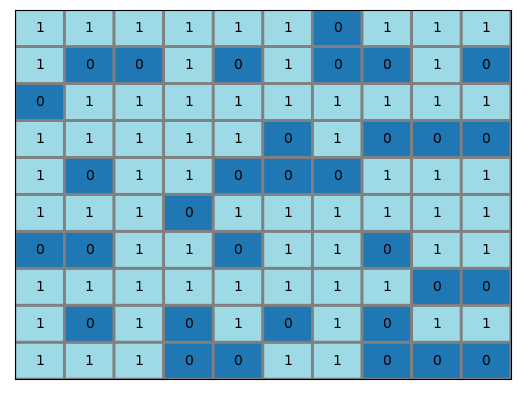

(316.0, 0.033944129943847656)

In [9]:
from mip import *
def mip(g):
    st=timeit.default_timer()
    if len(g) == 0:
        return 0,0
    w,h=len(g),len(g[0])
    rect=[]
    gg = [[[] for i in range(h)] for j in range(w)]
    for i in range(w):
        for j in range(h):
            if g[i][j]!=0:
                d=h
                for ii in range(i,w):
                    for jj in range(j,d):
                        if g[ii][jj]==0: 
                            d=jj
                            break
                        for iii in range(i,ii+1):
                            for jjj in range(j,jj+1):
                                gg[iii][jjj].append((i,j,ii,jj))
                        rect.append((i,j,ii,jj))
    rechte=timeit.default_timer()-st
    m = Model(solver_name=CBC)
    vars = {}
    for i in rect:
        vars[i] = m.add_var(var_type=BINARY,name='Rects')
    st=timeit.default_timer()
    for i in range(w):
        for j in range(h):
            if g[i,j]!=0:
                m += xsum(vars[x] for x in gg[i][j]) == 1
    m.objective = maximize(xsum(vars[x]*(x[2]-x[0]+1)*(x[3]-x[1]+1)*(x[2]-x[0]+1)*(x[3]-x[1]+1) for x in rect))
    start_time = time.time()
    m.verbose = 0
    m.optimize()

    end_time = time.time()
    runtime = end_time - start_time
    return m.objective_value, runtime
g = start(10,10)
plotp(g)
mip(g)